In [1]:
%matplotlib inline
import scipy.io
import datetime
import matplotlib as plt
import numpy as np
import pandas as pd
from astropy.time import Time
from dateutil import parser
from my_project import *
pd.options.display.mpl_style = 'default'
import mpld3
mpld3.enable_notebook()

In [2]:
def predict(times,amps,phases):
    import numpy as np
    from pytides.tide import Tide
    import pytides.constituent as cons
    from datetime import datetime
    
    constituents = [cons._M2,cons._N2,cons._S2,cons._O1,cons._K1,cons._K2,cons._P1,cons._Q1]

    model = np.zeros(len(constituents), dtype = Tide.dtype)
    model['constituent'] = constituents
    model['amplitude'] = amps
    model['phase'] = phases

    tide = Tide(model = model, radians = False)
    
    pred=tide.at(times)
    return pred

In [3]:
# load FVCOM bottom temp
f=scipy.io.netcdf_file('/Users/cliu/Documents/hydra/cliu/bottom_temp/gom3v12_btemp_davged_2014-2015.nc','r')

In [4]:
fvcom_x=f.variables['x'][:]
fvcom_y=f.variables['y'][:]
#fvcom_tri=f.variables['nv'][:].T
fvcom_time=f.variables['time'][:]
fvcom_h=f.variables['h'][:]
fvcom_temp=f.variables['temp'][:]

In [5]:
# load tidal database
fvcomdb=scipy.io.loadmat('/Users/cliu//Dropbox/Geolocation/preprocess/gen_tidal_db/fvcomdb_gom3_v2.mat',squeeze_me =False,struct_as_record=True)
fvcomdb=fvcomdb['fvcom']

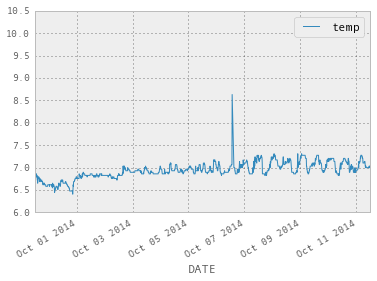

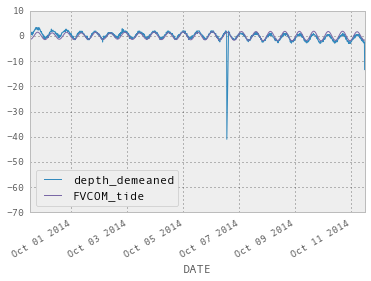

In [8]:
tag=scipy.io.loadmat('../68_raw.mat',squeeze_me =False,struct_as_record=True)
tag=tag['tag']
dnum=tag['dnum'][0,0][:,0]
temp=tag['temp'][0,0][:,0]
depth=tag['depth'][0,0][:,0]
dnum=dnum-678942
idx=depth>20

data=pd.DataFrame({'dnum':dnum[idx],'temp':temp[idx],'depth':depth[idx]})
data['DATE']=Time(data.dnum,format='mjd',scale='utc').datetime
data['DATE']=pd.to_datetime(data['DATE'])
data['depth_demeaned']= data.depth-data.depth.mean()

release_lon=tag['release_lon'][0,0].squeeze()
release_lat=tag['release_lat'][0,0].squeeze()

xr,yr=my_project(release_lon,release_lat,'forward')
dist=np.sqrt((fvcom_x-xr)**2+(fvcom_y-yr)**2)
node=np.where(dist==dist.min())

tbeg=np.floor(Time(data.loc[0].DATE,scale='utc').mjd)
tend=np.ceil(Time(data.iloc[-1].DATE,scale='utc').mjd)
time_idx=(fvcom_time>=tbeg) & (fvcom_time<=tend+1)
time_f=Time(fvcom_time[time_idx],format='mjd',scale='utc')
temp_f=fvcom_temp[time_idx,node]

ts=pd.Series(temp_f[0], index=time_f.datetime)

plt.pyplot.figure(figsize=(12,4))
data.plot(x='DATE',y='temp')
#ts.plot()

# construct tidal signal
amps = 0.01*fvcomdb['amp'][0,0][node]
phases = fvcomdb['phase'][0,0][node]
tag_time=[i for i in data.DATE]
pred=predict(tag_time,amps,phases)


data['FVCOM_tide']=pred

plt.pyplot.figure(figsize=(12,4))
data.plot(x='DATE',y=['depth_demeaned','FVCOM_tide'])

In [ ]:
data.DATE.describe()

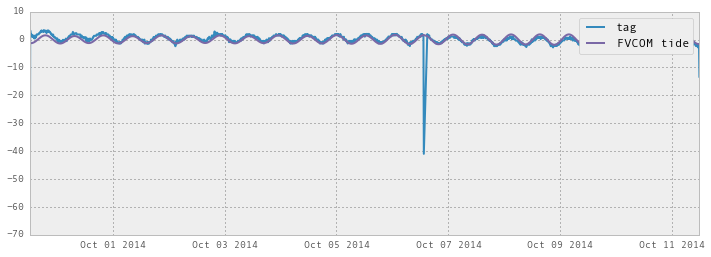

In [11]:
plt.pyplot.figure(figsize=(12,4))
plt.pyplot.plot(data['DATE'],data['depth_demeaned'],label='tag',linewidth=2)
plt.pyplot.plot(data['DATE'],data['FVCOM_tide'],label='FVCOM tide',linewidth=2)
plt.pyplot.legend()
#data.plot(x='DATE',y=['depth_demeaned','FVCOM_tide'])